# PSD

PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).

author: steeve.laquitaine@epfl.ch

**Execution duration:** : 10 mins for 10 min recordings

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * run: 2023_10_18
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)

Power is energy per time: can be compared between traces of different durations (sample length).

### Setup

1. Activate `spikeinterf..` venv

2. precompute data with: $ sbatch cluster/figures/main/marques/psd_10m_buttw_noise_fitd_raw_welch.sbatch

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import scipy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

matplotlib.rcParams['agg.path.chunksize'] = 10000


# SETUP PARAMETERS
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency

# SETUP DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]
POWER_RAW_vivo = data_conf_vivo["analyses"]["traces"]["power"]["raw"]
POWER_PREP_vivo = data_conf_vivo["analyses"]["traces"]["power"]["preprocessed"]

# silico
data_conf_sili, param_conf_sili = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_sili_adj = data_conf_sili["probe_wiring"]["40m"]["output_noise_fitd_gain_fitd_adj_int16"]
PREP_PATH_sili_adj = data_conf_sili["preprocessing"]["output"]["40m"]["trace_file_path_gain_fitd_adj_noise_fitd_int16"]

RAW_PATH_sili = data_conf_sili["probe_wiring"]["output"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]

# Buccino with fitted gain for layer 5
data_conf_b, _ = get_config("buccino_2020", "2020").values()
RAW_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["raw_gain_ftd"]
PREP_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["prep_gain_ftd"]


# FIGURE SETTINGS
FIG_SIZE = (8, 3.5)
COLOR_VIVO = np.array([153,153,153]) / 255
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_BUCCI = np.array([55,126,184]) / 255
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['lines.linewidth'] = 1.1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.8 * 1.2
plt.rcParams['xtick.major.size'] = 3.5 * 1.2
plt.rcParams['xtick.minor.size'] = 2 * 1.2
plt.rcParams['ytick.major.size'] = 3.5 * 1.2
plt.rcParams['ytick.major.width'] = 0.8 * 1.2
plt.rcParams['ytick.minor.size'] = 2 * 1.2

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-06-02 19:48:29,086 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-02 19:48:29,144 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-02 19:48:29,147 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-02 19:48:29,368 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-02 19:48:29,380 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-02 19:48:29,479 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Utils

In [2]:
def load_saved_traces_in_ctx():

    # vivo
    raw_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
    )
    prep_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/preprocessed/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
    )

    # silico
    raw_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/dataeng/recording/traces_in_ctx_10m_noise_ftd_gain_ftd_adj.npy"
    )

    prep_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/preprocessed/traces_in_ctx_10m_noise_ftd_gain_ftd_adj.npy"
    )
    return raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili


def load_psd_results():

    # save sili
    out_raw_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_raw_power_welch_noise_ftd_gain_ftd_adj_10m.npy",
        allow_pickle=True,
    )
    out_raw_sili = out_raw_sili.item()

    out_prep_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_prep_buttw_power_welch_noise_ftd_gain_ftd_adj_10m.npy",
        allow_pickle=True,
    )
    out_prep_sili = out_prep_sili.item()

    # save vivo
    out_raw_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_raw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_raw_vivo = out_raw_vivo.item()

    out_prep_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_prep_buttw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_prep_vivo = out_prep_vivo.item()
    return out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo


def plot_power_for_layer(
    layer: str,
    site_layers_sili: list,
    site_layers_vivo: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
    out_prep_vivo: dict,
    out_prep_sili: dict,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Select traces in layer

    # raw
    raw_power_sili_layer_i = out_raw_sili["power"][site_layers_sili == layer, :]
    raw_power_vivo_layer_i = out_raw_vivo["power"][site_layers_vivo == layer, :]

    # preprocessed
    prep_power_sili_layer_i = out_prep_sili["power"][site_layers_sili == layer, :]
    prep_power_vivo_layer_i = out_prep_vivo["power"][site_layers_vivo == layer, :]

    # Raw panel --------------------------------

    # VIVO
    psd_mean = np.mean(raw_power_vivo_layer_i, axis=0)
    axes[0].plot(
        out_raw_vivo["freq"],
        psd_mean,  # / psd_mean.mean(),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(raw_power_sili_layer_i, axis=0)
    axes[0].plot(
        out_raw_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    # axes[0].set_ylabel("Power (ratio)")
    # axes[0].set_yscale("log")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([-1, SFREQ_SILICO / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[0].tick_params(which="both", width=1)
    # axes[0].xaxis.set_major_locator(locmaj)
    # axes[0].xaxis.set_minor_locator(locmin)
    # axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # Preprocessed panel --------------------------------

    # VIVO
    psd_mean = np.mean(prep_power_vivo_layer_i, axis=0)
    axes[1].plot(
        out_prep_vivo["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(prep_power_sili_layer_i, axis=0)
    axes[1].plot(
        out_prep_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_xscale("log")
    axes[1].spines[["left", "right", "top"]].set_visible(False)
    axes[1].set_yticklabels([])
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    # axes[1].legend(**legend_cfg)
    axes[1].set_ylim(YLIM_P)

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[1].tick_params(which="both", width=1)
    # axes[1].xaxis.set_major_locator(locmaj)
    # axes[1].xaxis.set_minor_locator(locmin)
    # axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    axes[1].set_xlim([-1, SFREQ_SILICO / 2])
    axes[1].tick_params(axis="x", which="minor", colors="black")
    axes[1].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[1].tick_params(which="both")
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    fig.tight_layout(**tight_layout_cfg)
    return axes

### (1s)Load dataset

In [6]:
# Load traces
# load raw traces
RawVivo = si.load_extractor(RAW_PATH_vivo)
RawSili = si.load_extractor(RAW_PATH_sili)

# load preprocessed traces
PreprocessedVivo = si.load_extractor(PREP_PATH_vivo)
PreprocessedSili = si.load_extractor(PREP_PATH_sili)

# select first 10 minutes
RawVivo = RawVivo.frame_slice(start_frame=0, end_frame=SFREQ_VIVO * 10 * 60)
PreprocessedVivo = PreprocessedVivo.frame_slice(
    start_frame=0, end_frame=SFREQ_VIVO * 10 * 60
)
RawSili = RawSili.frame_slice(start_frame=0, end_frame=SFREQ_SILICO * 10 * 60)
PreprocessedSili = PreprocessedSili.frame_slice(
    start_frame=0, end_frame=SFREQ_SILICO * 10 * 60
)

# sanity check
assert RawSili.get_total_duration() == 10 * 60, "not 10 min"
assert RawVivo.get_total_duration() == 10 * 60, "not 10 min"

#### (1s)Keep cortical sites

In [4]:
# Keep traces from good sites (in cortex)

# silico
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_sili = RawSili.get_property("layers")
site_layers_sili = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_sili
]
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# vivo
site_layers_vivo = RawVivo.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]

# keep only the layers
site_layers_sili = np.array(site_layers_sili)[sites_sili]
site_layers_vivo = np.array(site_layers_vivo)[sites_vivo]

#### (20s)Load traces and PSD in ctx

In [7]:
# load traces and PSD Marques
raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili = (
    load_saved_traces_in_ctx()
)
out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo = load_psd_results()

# load PSD Buccino (l5)
out_raw_b = np.load(RAW_PATH_GAIN_FTD_B, allow_pickle=True).item()
out_prep_b = np.load(PREP_PATH_GAIN_FTD_B, allow_pickle=True).item()

# unit-test
assert out_raw_vivo["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert out_raw_sili["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert out_raw_b["freq"][1] == 1.0, "psd resolution should be 1Hz"

#### (1s) Plot column

The PSD is averaged over sites by layer. We used the median of the mean due to the small number of sites per layer.

In [9]:
# (11s) average over sites
psd_mean_raw_vivo = np.median(out_raw_vivo["power"], axis=0)
psd_mean_raw_sili = np.median(out_raw_sili["power"], axis=0)
psd_mean_raw_b = np.median(out_raw_b["power"], axis=0)
psd_mean_prep_vivo = np.median(out_prep_vivo["power"], axis=0)
psd_mean_prep_sili = np.median(out_prep_sili["power"], axis=0)
psd_mean_prep_b = np.median(out_prep_b["power"], axis=0)

# confidence intervals
# vivo
n_samples = out_raw_vivo["power"].shape[0]
ci_raw_vivo = 1.96 * np.std(out_raw_vivo["power"], axis=0) / np.sqrt(n_samples)
ci_prep_vivo = 1.96 * np.std(out_prep_vivo["power"], axis=0) / np.sqrt(n_samples)
# sili
n_samples = out_raw_sili["power"].shape[0]
ci_raw_sili = 1.96 * np.std(out_raw_sili["power"], axis=0) / np.sqrt(n_samples)
ci_prep_sili = 1.96 * np.std(out_prep_sili["power"], axis=0) / np.sqrt(n_samples)
# buccino
n_samples = out_raw_b["power"].shape[0]
ci_raw_b = 1.96 * np.std(out_raw_b["power"], axis=0) / np.sqrt(n_samples)
ci_prep_b = 1.96 * np.std(out_prep_b["power"], axis=0) / np.sqrt(n_samples)

#### Mann Whitney stats

* null hypothesis: the biophysical model and in vivo power spectra are the same, below 100 Hz.
* method: we used Mann Whitney to compare in vivo and simulated psd in rolling windows of size 5.

In [10]:
# compare biophysical model with in vivo PSD
# # find indices of 100 Hz
ix_100_hz_vivo = np.where(out_raw_vivo["freq"] == 100)[0][0]
ix_100_hz_sili = np.where(out_raw_vivo["freq"] == 100)[0][0]


def rolling_mw_test(sample_x, sample_y, window_size: int = 5):
    results = []
    pvalues = []
    for i in range(sample_x.shape[1] - window_size + 1):
        result = scipy.stats.mannwhitneyu(
            sample_x[:, i : i + window_size].flatten(),
            sample_y[:, i : i + window_size].flatten(),
        )
        # store results
        results.append(result)
        pvalues.append(result.pvalue)
    return (np.array(pvalues), results)


window_size = 5

# stats raw
pvalues_raw, results_raw = rolling_mw_test(
    out_raw_vivo["power"], out_raw_sili["power"], 5
)

# stats preprocessed
pvalues_prep, results_prep = rolling_mw_test(
    out_prep_vivo["power"], out_prep_sili["power"], 5
)

# statistically significantly different (=1)
pvalues005_raw = (pvalues_raw < 0.05).astype(float)
pvalues005_prep = (pvalues_prep < 0.05).astype(float)

print("ratio of significant windows (raw):", sum(pvalues005_raw) / len(pvalues005_raw))
print(
    "ratio of significant windows (prep):", sum(pvalues005_prep) / len(pvalues005_prep)
)
print("max pvalue below 0.05 (raw):", max(pvalues_raw[pvalues_raw < 0.05]))
print("max pvalue below 0.05 (prep):", max(pvalues_prep[pvalues_prep < 0.05]))

ratio of significant windows (raw): 0.9977995599119824
ratio of significant windows (prep): 0.9990664799626592
max pvalue below 0.05 (raw): 0.044689786077797444
max pvalue below 0.05 (prep): 0.040904787146031435


### Plot

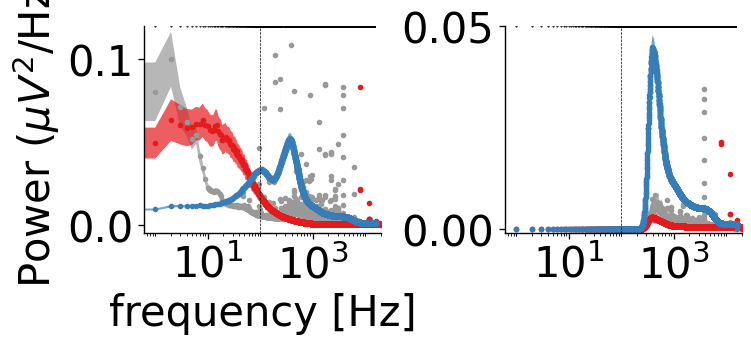

In [11]:
# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_R = [-0.005, 0.12]
YLIM_P = [-0.001, 0.05]
N_MAJOR_TICKS = 4
SIZE = 3
ALPHA = 0.7
fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------

# VIVO

# 3 secs
axes[0].plot(
    out_raw_vivo["freq"],
    psd_mean_raw_vivo,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_VIVO,
    label="vivo",
    rasterized=True,
)
axes[0].plot(
    out_raw_sili["freq"],
    psd_mean_raw_sili,
    color=COLOR_SILI,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="silico",
    rasterized=True,
)
axes[0].plot(
    out_raw_b["freq"],
    psd_mean_raw_b,
    color=COLOR_BUCCI,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    label="Buccino",
    rasterized=True,
)

# confidence interval
axes[0].fill_between(
    out_raw_vivo["freq"],
    (psd_mean_raw_vivo - ci_raw_vivo),
    (psd_mean_raw_vivo + ci_raw_vivo),
    color=COLOR_VIVO,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[0].fill_between(
    out_raw_sili["freq"],
    (psd_mean_raw_sili - ci_raw_sili),
    (psd_mean_raw_sili + ci_raw_sili),
    color=COLOR_SILI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[0].fill_between(
    out_raw_b["freq"],
    (psd_mean_raw_b - ci_raw_b),
    (psd_mean_raw_b + ci_raw_b),
    color=COLOR_BUCCI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# STATS: mark pvalues < 0.05
x = out_raw_vivo["freq"][np.where(pvalues005_raw == 1)[0]]
y = pvalues005_raw[np.where(pvalues005_raw == 1)[0]] * YLIM_R[1]
axes[0].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[0].vlines(
    x=100, ymin=YLIM_R[0], ymax=YLIM_R[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[0].set_xscale("log")
axes[0].set_xlim([0, SFREQ_SILICO / 2])
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylim(YLIM_R)
axes[0].set_ylabel("Power ($\mu V^2$/Hz)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[0].set_xticklabels([])

# Preprocessed panel ************************************************************
axes[1].plot(
    out_prep_vivo["freq"],
    psd_mean_prep_vivo,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_VIVO,
    label="vivo",
    rasterized=True,
)
axes[1].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_SILI,
    label="silico",
    rasterized=True,
)
axes[1].plot(
    out_prep_b["freq"],
    psd_mean_prep_b,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_BUCCI,
    label="Buccino",
    rasterized=True,
)

# confidence interval
axes[1].fill_between(
    out_prep_vivo["freq"],
    (psd_mean_prep_vivo - ci_prep_vivo),
    (psd_mean_prep_vivo + ci_prep_vivo),
    color=COLOR_VIVO,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[1].fill_between(
    out_prep_sili["freq"],
    (psd_mean_prep_sili - ci_prep_sili),
    (psd_mean_prep_sili + ci_prep_sili),
    color=COLOR_SILI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[1].fill_between(
    out_prep_b["freq"],
    (psd_mean_prep_b - ci_prep_b),
    (psd_mean_prep_b + ci_prep_b),
    color=COLOR_BUCCI,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)


# mark pvalues < 0.05
x = out_prep_vivo["freq"][np.where(pvalues005_prep == 1)[0]]
y = pvalues005_prep[np.where(pvalues005_prep == 1)[0]] * YLIM_P[1]
axes[1].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[1].vlines(
    x=100, ymin=YLIM_P[0], ymax=YLIM_P[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axes[1].set_ylim(YLIM_P)
axes[1].set_xlim([-1, SFREQ_SILICO / 2])

fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[1].get_legend().remove()

# save (12MB figure)
# plt.savefig(
#     "figures/2_realism/4_power/svg/marques/marques_10m_psd_column_raw_welch_and_stats.svg",
#     **savefig_cfg
# )

#### plot layer 1

[Text(0.001, 0, ''),
 Text(0.09999999999999999, 0, ''),
 Text(10.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(100000.0, 0, ''),
 Text(10000000.0, 0, '')]

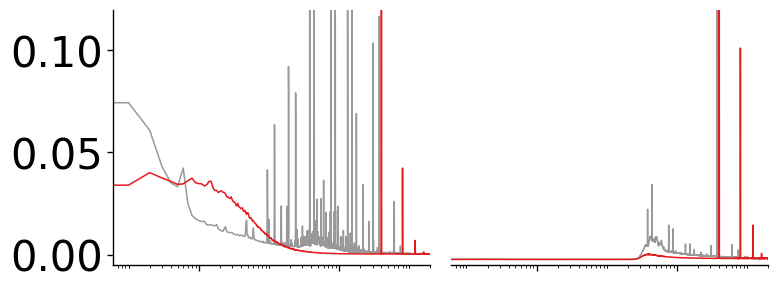

In [12]:
# takes 50 secs
axes = plot_power_for_layer(
    "L1",
    site_layers_sili,
    site_layers_vivo,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
# plt.savefig(
#     "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer1_column_raw_welch.svg",
#     **savefig_cfg
# )

#### plot layer 2/3

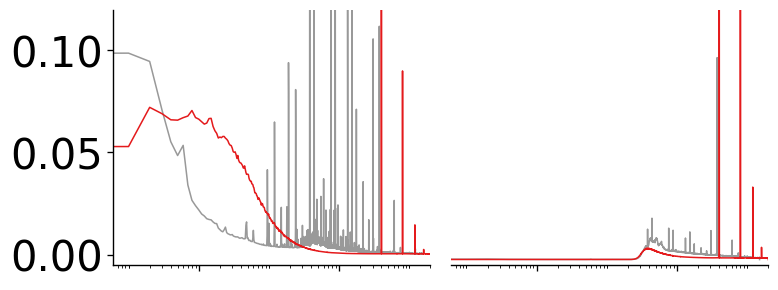

In [13]:
# takes 50 secs
axes = plot_power_for_layer(
    "L2_3",
    site_layers_sili,
    site_layers_vivo,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# plt.savefig(
#     "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer2_3_column_raw_welch.svg",
#     **savefig_cfg
# )

#### plot layer 4

[Text(0.001, 0, ''),
 Text(0.09999999999999999, 0, ''),
 Text(10.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(100000.0, 0, ''),
 Text(10000000.0, 0, '')]

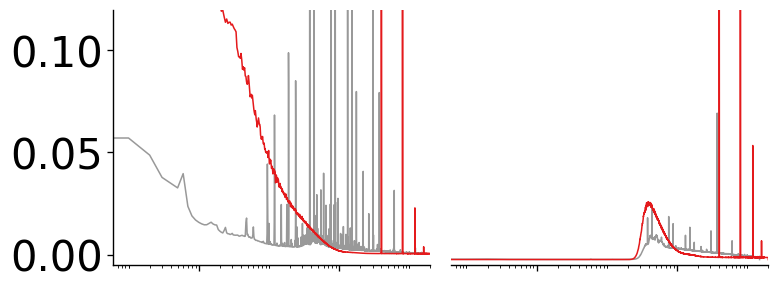

In [14]:
# takes 50 secs
axes = plot_power_for_layer(
    "L4",
    site_layers_sili,
    site_layers_vivo,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
# plt.savefig(
#     "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer4_column_raw_welch.svg",
#     **savefig_cfg
# )

#### plot layer 5

[Text(0.001, 0, ''),
 Text(0.09999999999999999, 0, ''),
 Text(10.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(100000.0, 0, ''),
 Text(10000000.0, 0, '')]

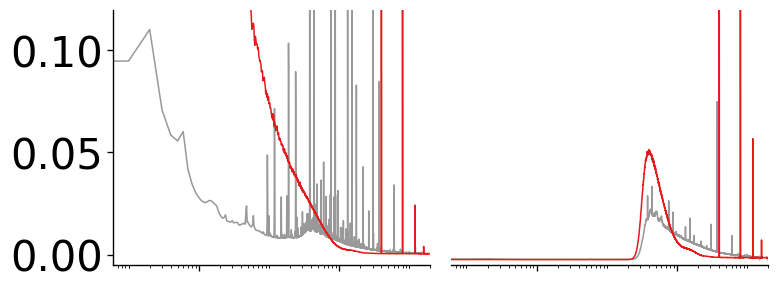

In [15]:
# takes 50 secs
axes = plot_power_for_layer(
    "L5",
    site_layers_sili,
    site_layers_vivo,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# plt.savefig(
#     "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer5_column_raw_welch.svg",
#     **savefig_cfg
# )

#### plot layer 6

Text(0.5, -20.250000000000007, 'Frequency (Hz)')

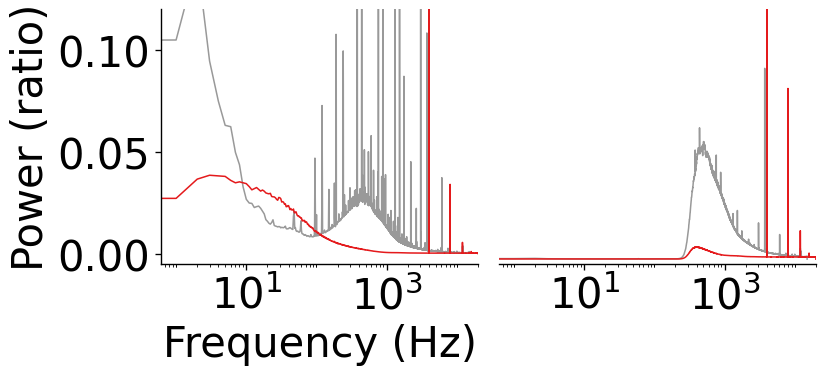

In [16]:
# takes 50 secs
axes = plot_power_for_layer(
    "L6",
    site_layers_sili,
    site_layers_vivo,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)
axes[0].set_ylabel("Power (ratio)")
axes[0].set_xlabel("Frequency (Hz)")

# plt.savefig(
#     "figures/2_realism/4_power/svg/marques/marques_10m_psd_layer6_column_raw_welch.svg",
#     **savefig_cfg
# )

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
